In [2]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os
import random

# from image processing
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.callbacks import EarlyStopping

# ignore the harmless warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
path_to_zip = '/content/traffic_sign_data_split.zip'
dir_to_extract = '/content'

#extraction
with zipfile.ZipFile(path_to_zip, 'r') as zip_ref:
    zip_ref.extractall(dir_to_extract)

In [7]:
# path to raw train data
train_path ='/content/traffic signs split/train'
val_path ='/content/traffic signs split/val'

# listing the subdirectory
sub_dir = os.listdir(train_path)
val_dir = os.listdir(val_path)

labels = pd.read_csv('/content/labels.csv')
labels.head()

,ClassId,Name
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)


In [9]:
# Checking Number of Classes
print("Number of Classes in train_directory: ", len(sub_dir))
print("Number of Classes in Val directory: ", len(val_dir))
print("Number of Classes in labels csv: ", labels['ClassId'].nunique())

Number of Classes in train_directory:  43
Number of Classes in Val directory:  43
Number of Classes in labels csv:  43


In [11]:
# Numbes of Images in under each class
# Training Set
train_classes={}
for dir in sub_dir:
  folder = os.path.join(train_path, dir)
  train_classes[int(dir)] = len(os.listdir(folder))

# Append the number of images in each class to dataframe
labels['Train_images'] = labels['ClassId'].map(train_classes)

# VALIDATION SET
val_classes={}
for dir in val_dir:
  folder = os.path.join(val_path, dir)
  val_classes[int(dir)] = len(os.listdir(folder))

# Append the number of images in each class to dataframe
labels['Val_images'] = labels['ClassId'].map(val_classes)

labels.head()



,ClassId,Name,Train_images,Val_images
0,0,Speed limit (20km/h),360,91
1,1,Speed limit (30km/h),3936,984
2,2,Speed limit (50km/h),2088,522
3,3,Speed limit (60km/h),2136,534
4,4,Speed limit (70km/h),3000,750


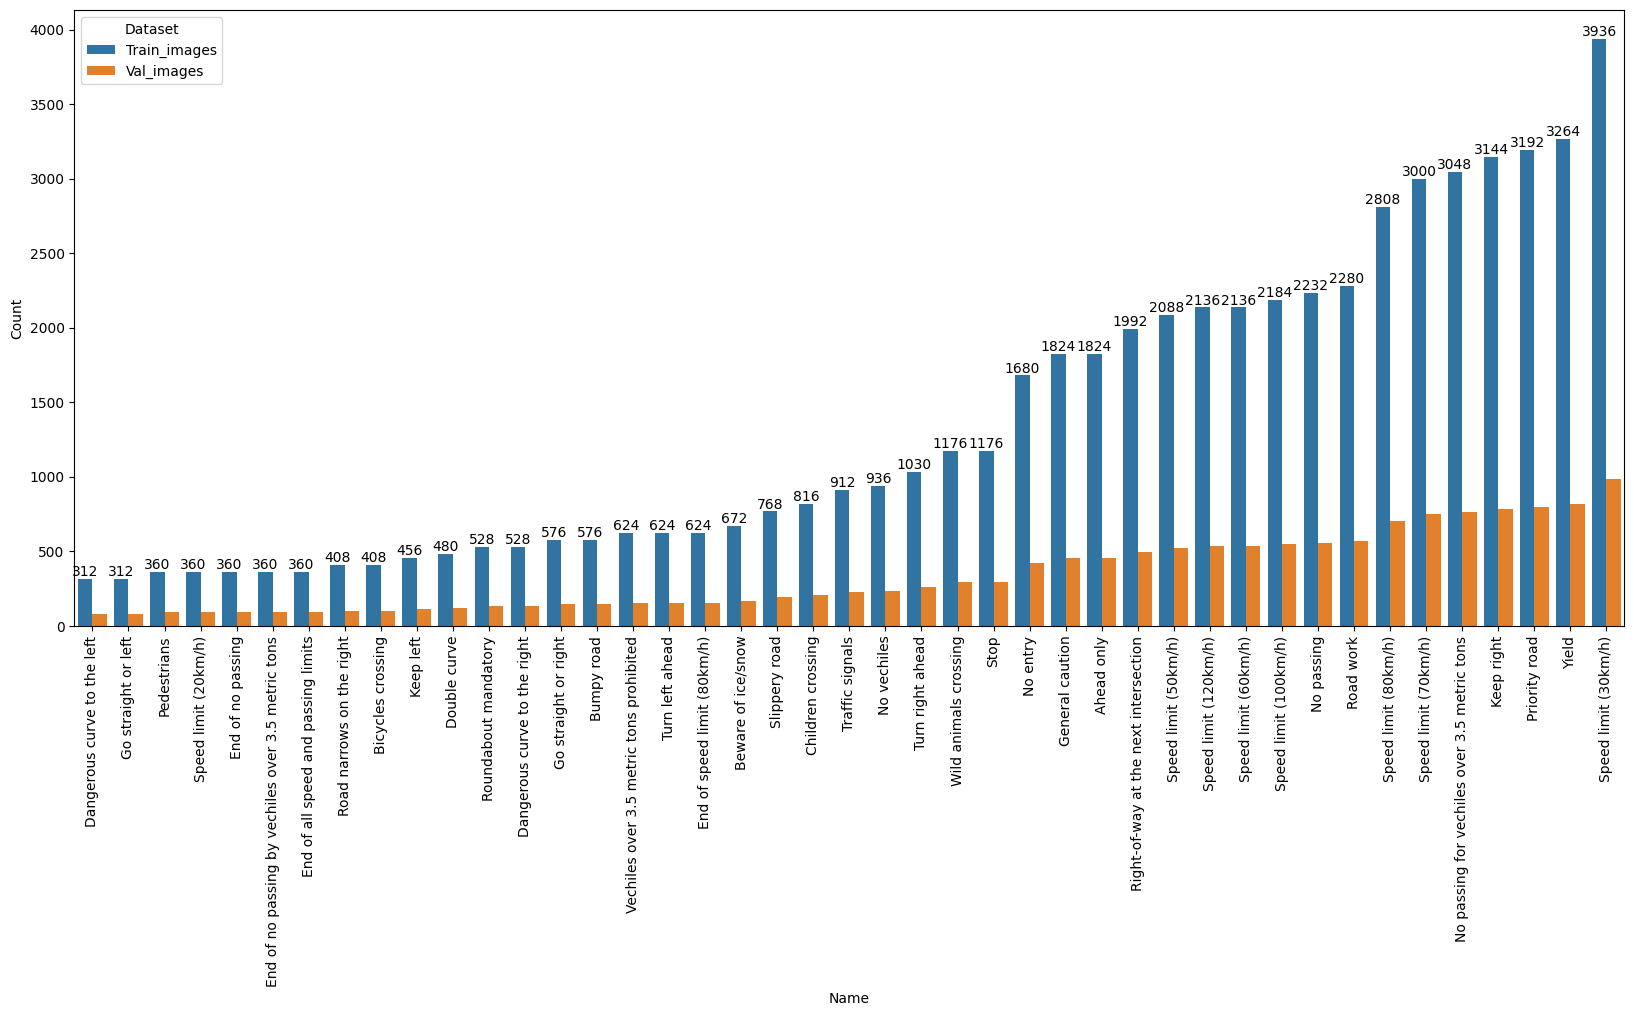

Total Number of Images in Train: 58510
Total Number of Images in Val: 14629


In [18]:
labels_melted = labels.melt(
    id_vars=['Name'],
    value_vars=['Train_images','Val_images'],
    var_name='Dataset',
    value_name='Count'
)

plt.figure(figsize=(20,8))
ax = sns.barplot(
    data=labels_melted,
    x='Name', y='Count', hue='Dataset',
    order=labels.sort_values(['Train_images'])['Name']
)
ax.bar_label(ax.containers[0])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

# total number of images cummulatively
print('Total Number of Images in Train:', labels['Train_images'].sum())
print('Total Number of Images in Val:', labels['Val_images'].sum())

Data is imbalanced, we will be using Data augmentation before modelling.

In [19]:
# Check the resolution of image:
res = cv2.imread(os.path.join(data_path, sub_dir[0], os.listdir(os.path.join(data_path, sub_dir[0]))[0])).shape
print('Height: ', res[0])
print('Width: ', res[1])
print('Layers: ', res[2])
print(f'Image Resolution: {res[1]} x {res[0]}')


Height:  32
Width:  32
Layers:  3
Image Resolution: 32 x 32


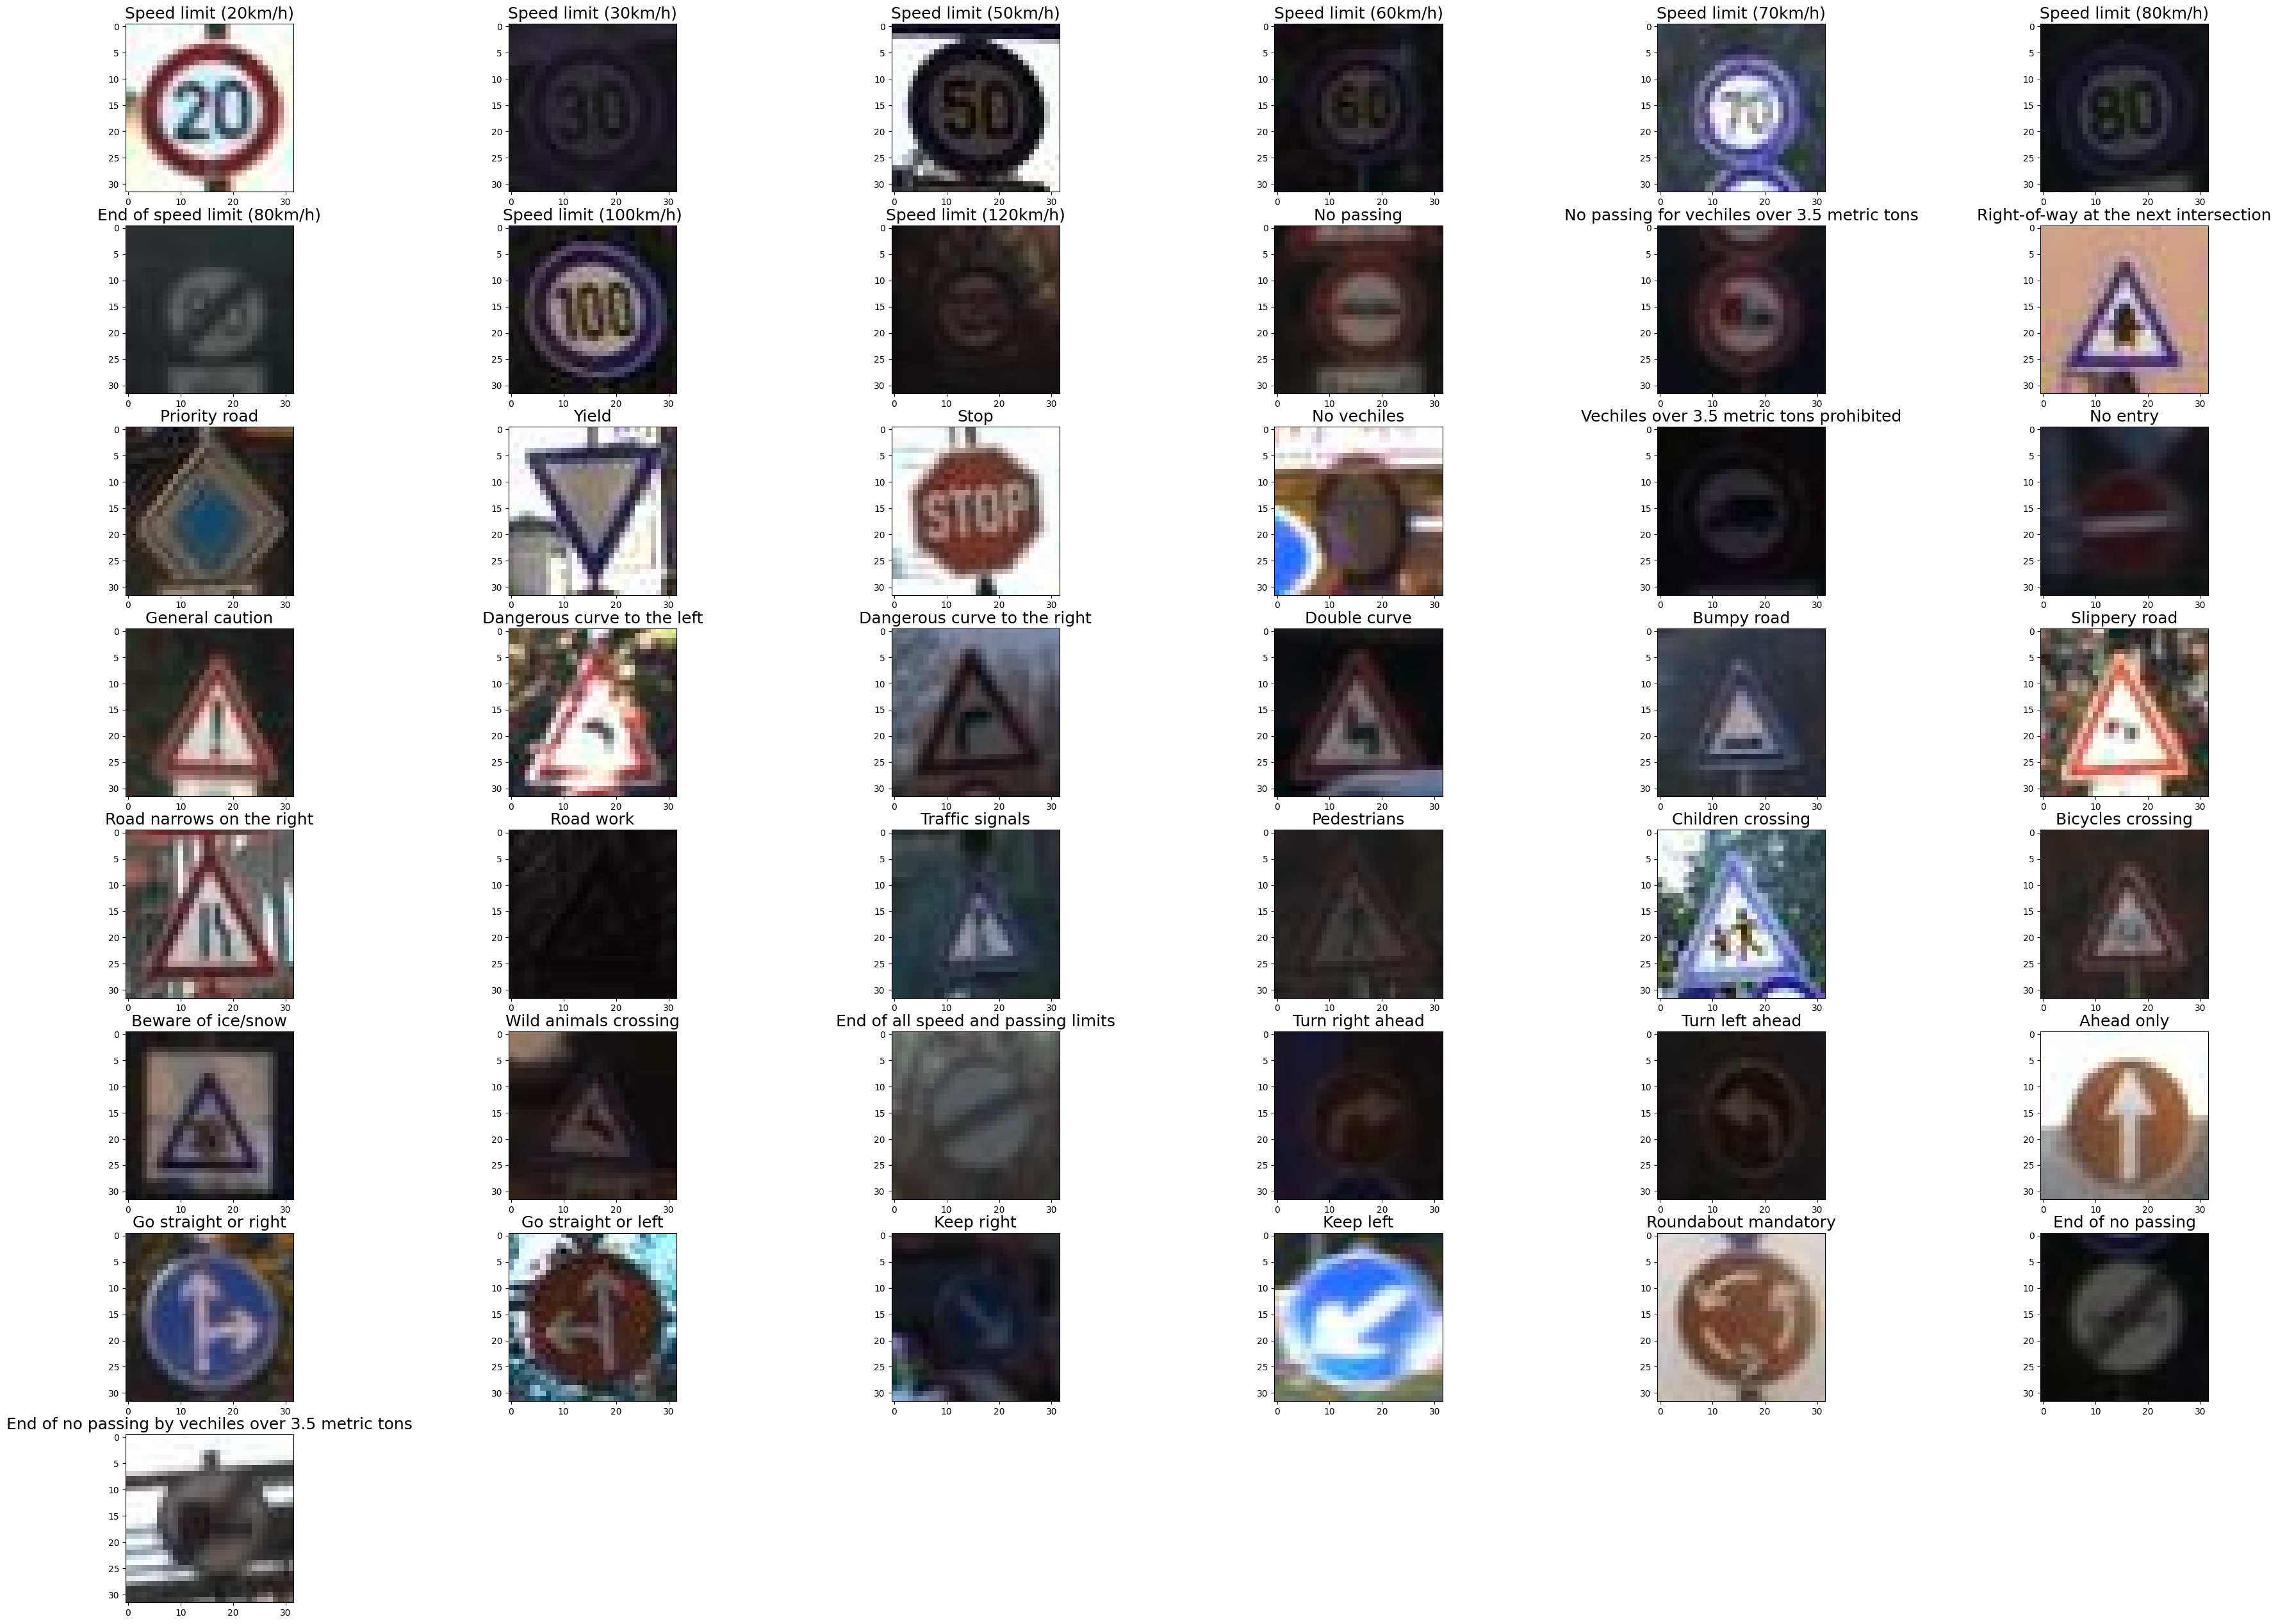

In [21]:
# Display Images randomly from each class
fig = plt.figure(figsize=(45,32))
rw, cl = 8, 6
for dir in sub_dir:
  cur_dir_file = os.listdir(os.path.join(train_path, dir))
  img = cv2.imread(os.path.join(train_path, dir, cur_dir_file[random.randint(0, len(cur_dir_file))]))
  fig.add_subplot(rw, cl, int(dir)+1)
  plt.imshow(img)
  plt.title(labels['Name'][int(dir)], fontsize=18)

In [22]:
# Data Augumentation

train_data_gen = ImageDataGenerator(rescale=1./255,
                                    rotation_range=20,
                                    zoom_range=0.2,
                                    fill_mode='nearest').flow_from_directory('/content/traffic signs split/train',
                                                                             target_size=(32, 32),
                                                                             batch_size=32,
                                                                             class_mode='categorical')

val_data_gen = ImageDataGenerator(rescale=1./255).flow_from_directory('/content/traffic signs split/val',
                                                                             target_size=(32, 32),
                                                                             batch_size=32,
                                                                             class_mode='categorical')

Found 58510 images belonging to 43 classes.
Found 14629 images belonging to 43 classes.


## CNN Model

In [23]:
# function to create the model

def create_model(activation='relu'):

    """ Creates and returns image classification model

    Args:
        activation(str) : Activation function to be used in first few layers.

    Returns:
        model (keras model): Compiled image classification model.

    """

    model = Sequential([
        Conv2D(16, (3, 3), activation=activation, input_shape=(32, 32, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(32, (3, 3), activation=activation),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation=activation),

        Flatten(),

        Dense(512, activation=activation),
        Dense(256, activation='tanh'),
        Dense(128, activation=activation),
        Dense(43, activation='softmax')])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [24]:
# create a model
TrafficSignDetector = create_model()

# model architecture
TrafficSignDetector.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 43)             │         5,547 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 718,155 (2.74 MB)

 Trainable params: 718,155 (2.74 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# lets train the model
es = EarlyStopping(monitor='val_loss', mode='auto', verbose=4, patience=3)
history = TrafficSignDetector.fit(train_data_gen, validation_data=val_data_gen, epochs=10, callbacks=[es])

Epoch 1/10
1829/1829 ━━━━━━━━━━━━━━━━━━━━ 150s 80ms/step - accuracy: 0.5586 - loss: 1.5831 - val_accuracy: 0.9558 - val_loss: 0.1499
Epoch 2/10
1829/1829 ━━━━━━━━━━━━━━━━━━━━ 116s 63ms/step - accuracy: 0.9370 - loss: 0.2081 - val_accuracy: 0.9735 - val_loss: 0.0870
Epoch 3/10
1829/1829 ━━━━━━━━━━━━━━━━━━━━ 116s 63ms/step - accuracy: 0.9611 - loss: 0.1261 - val_accuracy: 0.9809 - val_loss: 0.0621
Epoch 4/10
1829/1829 ━━━━━━━━━━━━━━━━━━━━ 115s 63ms/step - accuracy: 0.9677 - loss: 0.0996 - val_accuracy: 0.9882 - val_loss: 0.0410
Epoch 5/10
1829/1829 ━━━━━━━━━━━━━━━━━━━━ 115s 63ms/step - accuracy: 0.9744 - loss: 0.0801 - val_accuracy: 0.9906 - val_loss: 0.0307
Epoch 6/10
1829/1829 ━━━━━━━━━━━━━━━━━━━━ 115s 63ms/step - accuracy: 0.9781 - loss: 0.0674 - val_accuracy: 0.9911 - val_loss: 0.0303
Epoch 7/10
1829/1829 ━━━━━━━━━━━━━━━━━━━━ 118s 65ms/step - accuracy: 0.9805 - loss: 0.0604 - val_accuracy: 0.9860 - val_loss: 0.0503
Epoch 8/10
1829/1829 ━━━━━━━━━━━━━━━━━━━━ 119s 65ms/step - accuracy: 

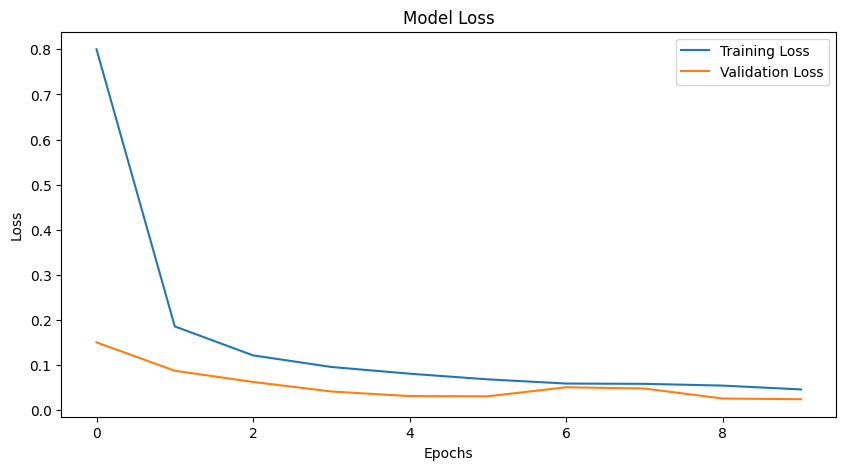

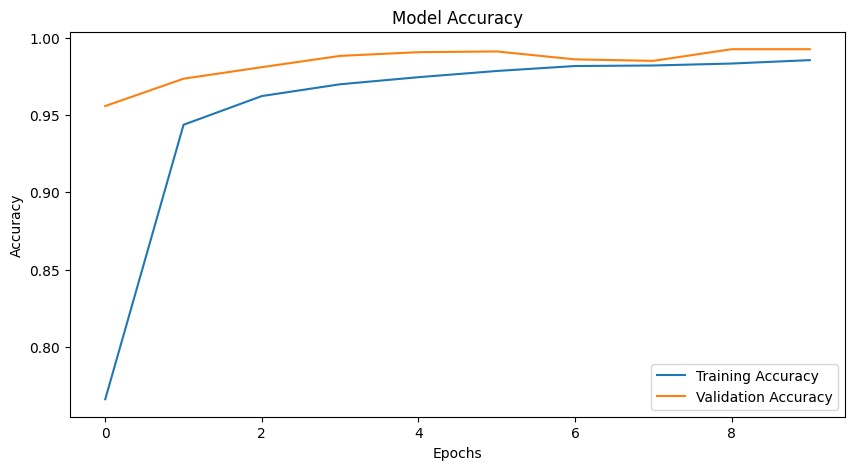

In [26]:
# Plot Loss
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Accuracy
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()